In [1]:
import warnings
warnings.filterwarnings('ignore')
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats

sns.set()

# Load results

To regenerate the benchmarking results from scratch, follow the instructions in README to set up data and submit all benchmarking jobs, and finall aggregate the main results to `aggregated_results/main_results.csv`.

Alternatively, if you do not wish to rerun all experiments, but only want to generate the plots, you can simply run the notebook using the provided results.

In [2]:
df = pd.read_csv("../aggregated_results/main_results.csv").rename(columns={"method": "model"})
df

,task_name,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc,network,label,model,runid
0,DOID:10124,-0.169167,-0.041181,0.174705,0.480013,0.522030,0.556767,humannet,disgenet,gat,2.0
1,DOID:76,0.022274,-0.229586,0.034293,0.498042,0.465230,0.480899,humannet,disgenet,gat,2.0
2,DOID:26,-0.115847,0.010322,0.181751,0.448857,0.427610,0.485520,humannet,disgenet,gat,2.0
3,DOID:0060032,0.150620,-0.073037,-0.118266,0.543790,0.506215,0.440046,humannet,disgenet,gat,2.0
4,DOID:0060158,0.262589,0.536660,0.584883,0.525513,0.544619,0.559546,humannet,disgenet,gat,2.0
...,...,...,...,...,...,...,...,...,...,...,...
42375,DOID:9834,2.698712,1.572180,1.933577,0.881217,0.650081,0.784621,string,disgenet,n2v-svm,2.0
42376,DOID:6419,4.969066,1.105346,0.852374,0.964832,0.549292,0.444653,string,disgenet,n2v-svm,2.0
42377,DOID:8534,2.834508,1.051787,1.940733,0.868061,0.678180,0.703120,string,disgenet,n2v-svm,2.0
42378,DOID:9370,3.912979,0.403573,2.128356,0.899354,0.515204,0.785265,string,disgenet,n2v-svm,2.0


In [3]:
networks = [
    "biogrid",
    "humannet",
    "string",
]
labels = ["disgenet", "gobp"]
models = [
    "adj-logreg",
    "adj-svm",
    "n2v-logreg",
    "n2v-svm",
    "labelprop",
    "gin",
    "gcn",
    "graphsage",
    "gat",
]

# Metric to plot
metric = "test_log2pr"

## Compare model performance across datasets

In [4]:
table = (
    df
    .groupby(["label", "network", "model"])
    .mean()[metric]
    .unstack("model")[models]
)

table.index = table.index.map("-".join)
table.index.name = table.columns.name = None
table.style.highlight_max(color="lightgreen", axis=1)

,adj-logreg,adj-svm,n2v-logreg,n2v-svm,labelprop,gin,gcn,graphsage,gat
disgenet-biogrid,0.773919,0.641985,0.743039,0.723508,0.813975,0.554939,0.512614,0.415074,0.264107
disgenet-humannet,1.898492,1.771645,1.651375,1.594197,1.873864,1.501812,1.007782,0.902817,0.374006
disgenet-string,2.603984,2.596474,2.438124,2.310741,2.616390,1.757780,1.115140,0.811764,nan
gobp-biogrid,1.686189,1.463770,1.875727,1.769724,1.248015,1.022436,1.011893,0.954289,0.338311
gobp-humannet,3.412612,3.271601,3.383089,3.230093,3.294126,2.850207,2.029906,1.681687,0.381959
gobp-string,3.481325,3.470232,3.728217,3.593208,3.422871,3.000047,1.941338,2.141114,nan


In [5]:
# Standard deviation across repetitions (each reduced via mean)
(
    df
    .groupby(["label", "network", "model", "runid"])
    .mean()
    .groupby(["label", "network", "model"])
    .std()[metric]
    .unstack("model")[models]
)

model              adj-logreg       adj-svm  n2v-logreg   n2v-svm  labelprop  \
label    network                                                               
disgenet biogrid          0.0  3.812982e-07    0.074014  0.024533        0.0   
         humannet         0.0  8.848850e-07    0.023523  0.029636        0.0   
         string           0.0  3.673797e-07    0.037249  0.067031        0.0   
gobp     biogrid          0.0  5.644923e-06    0.029418  0.035760        0.0   
         humannet         0.0  2.520645e-06    0.030869  0.040305        0.0   
         string           0.0  1.061819e-05    0.019381  0.056145        0.0   

model                   gin       gcn  graphsage       gat  
label    network                                            
disgenet biogrid   0.123044  0.023210   0.061663  0.008350  
         humannet  0.058543  0.068470   0.099744  0.072919  
         string    0.076818  0.030662   0.132280       NaN  
gobp     biogrid   0.041808  0.070070   0.078141  0.024970  
         humannet  0.015558  0.083616   0.186450  0.033829  
         string    0.078475  0.115957   0.155035       NaN

In [6]:
# Generate main (and supplemental) result tables for manuscript
grouped = (
    df
    .groupby(["label", "network", "model", "runid"])
    .mean()
    .groupby(["label", "network", "model"])
)

mean_df = grouped.mean()[metric].unstack("label")
std_df = grouped.std()[metric].unstack("label")

model_name_dict = {
    "adj-logreg": "Adj-LogReg",
    "adj-svm": "Adj-SVM",
    "n2v-logreg": "N2V-LogReg",
    "n2v-svm": "N2V-SVM",
    "labelprop": "LabelProp",
    "gin": "GIN",
    "gcn": "GCN",
    "graphsage": "GraphSAGE",
    "gat": "GAT",
}

for network in networks:
    print(network, mean_df.columns.values)

    models_to_use = models if network != "string" else [i for i in models if i != "gat"]
    mean = mean_df.query("network == @network").reset_index("network", drop=True).loc[models_to_use]
    std = std_df.query("network == @network").reset_index("network", drop=True).loc[models_to_use]
    for (i, m), (_, s) in zip(mean.iterrows(), std.iterrows()):
        print(f"{model_name_dict[i]} & " + " & ".join([f"{x:.2f} ± {y:.2f}" for x, y in zip(m, s)]) + r"\\")

    print()

biogrid ['disgenet' 'gobp']
Adj-LogReg & 0.77 ± 0.00 & 1.69 ± 0.00\\
Adj-SVM & 0.64 ± 0.00 & 1.46 ± 0.00\\
N2V-LogReg & 0.74 ± 0.07 & 1.88 ± 0.03\\
N2V-SVM & 0.72 ± 0.02 & 1.77 ± 0.04\\
LabelProp & 0.81 ± 0.00 & 1.25 ± 0.00\\
GIN & 0.55 ± 0.12 & 1.02 ± 0.04\\
GCN & 0.51 ± 0.02 & 1.01 ± 0.07\\
GraphSAGE & 0.42 ± 0.06 & 0.95 ± 0.08\\
GAT & 0.26 ± 0.01 & 0.34 ± 0.02\\

humannet ['disgenet' 'gobp']
Adj-LogReg & 1.90 ± 0.00 & 3.41 ± 0.00\\
Adj-SVM & 1.77 ± 0.00 & 3.27 ± 0.00\\
N2V-LogReg & 1.65 ± 0.02 & 3.38 ± 0.03\\
N2V-SVM & 1.59 ± 0.03 & 3.23 ± 0.04\\
LabelProp & 1.87 ± 0.00 & 3.29 ± 0.00\\
GIN & 1.50 ± 0.06 & 2.85 ± 0.02\\
GCN & 1.01 ± 0.07 & 2.03 ± 0.08\\
GraphSAGE & 0.90 ± 0.10 & 1.68 ± 0.19\\
GAT & 0.37 ± 0.07 & 0.38 ± 0.03\\

string ['disgenet' 'gobp']
Adj-LogReg & 2.60 ± 0.00 & 3.48 ± 0.00\\
Adj-SVM & 2.60 ± 0.00 & 3.47 ± 0.00\\
N2V-LogReg & 2.44 ± 0.04 & 3.73 ± 0.02\\
N2V-SVM & 2.31 ± 0.07 & 3.59 ± 0.06\\
LabelProp & 2.62 ± 0.00 & 3.42 ± 0.00\\
GIN & 1.76 ± 0.08 & 3.00 ± 0.08\\
GC

## Distribution of performance per task for a particular dataset

In [7]:
network = "humannet"
label = "disgenet"

summary_df = (
    df
    .groupby(
        ["task_name", "network", "label", "model"],
        as_index=False,
    )
    .mean()
    .query("network == @network & label == @label")
    .drop("runid", axis=1)
)
summary_df

,task_name,network,label,model,train_log2pr,val_log2pr,test_log2pr,train_auroc,val_auroc,test_auroc
9,DOID:0050117,humannet,disgenet,adj-logreg,4.241086,3.916112,4.534222,1.000000,0.751801,0.780205
10,DOID:0050117,humannet,disgenet,adj-svm,4.241086,3.823437,4.535368,1.000000,0.751057,0.785740
11,DOID:0050117,humannet,disgenet,gat,0.238551,0.384758,0.204929,0.510123,0.548645,0.486805
12,DOID:0050117,humannet,disgenet,gcn,2.181568,1.953899,2.114562,0.777697,0.599425,0.696450
13,DOID:0050117,humannet,disgenet,gin,3.334945,3.372914,4.202610,0.914514,0.721691,0.714982
...,...,...,...,...,...,...,...,...,...,...
3185,DOID:9993,humannet,disgenet,gin,4.694705,2.938070,2.945504,0.951401,0.784749,0.732169
3186,DOID:9993,humannet,disgenet,graphsage,4.230010,2.943000,2.224513,0.886157,0.733789,0.640430
3187,DOID:9993,humannet,disgenet,labelprop,5.468892,3.283265,3.983157,1.000000,0.833297,0.703673
3188,DOID:9993,humannet,disgenet,n2v-logreg,4.615578,3.529666,3.132254,0.964770,0.815680,0.698683


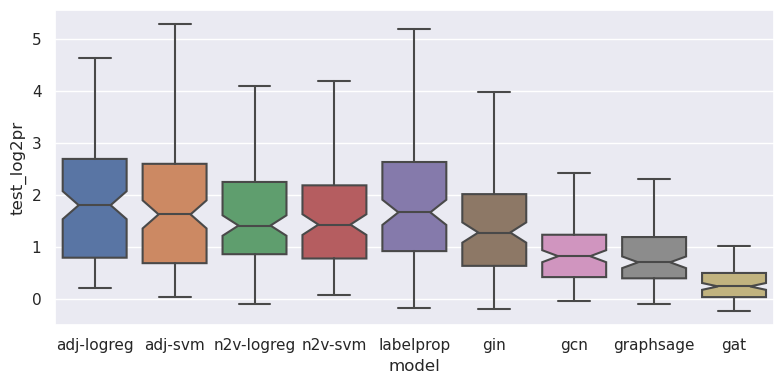

In [8]:
plt.figure(figsize=(8, 4))
sns.boxplot(
    data=summary_df,
    x="model",
    y=metric,
    order=models,
    notch=True,
    showfliers=False,
)
plt.tight_layout()
plt.show()

In [9]:
table = summary_df.pivot(index="task_name", columns="model", values=metric)
table

model,adj-logreg,adj-svm,gat,gcn,gin,graphsage,labelprop,n2v-logreg,n2v-svm
task_name,,,,,,,,,
DOID:0050117,4.534222,4.535368,0.204929,2.114562,4.202610,0.705017,4.669151,4.861026,4.919810
DOID:0050453,4.336055,4.368981,0.016319,0.952789,2.255180,0.971132,3.984226,2.026300,1.639578
DOID:0050567,1.143653,0.641946,0.036763,0.754757,1.463387,0.576110,1.451449,1.090376,1.185648
DOID:0050615,0.800005,0.803563,0.681694,1.064520,0.871747,0.403243,0.496889,1.959397,1.894407
DOID:0050621,0.798531,0.455129,0.336720,0.584158,0.938347,0.431894,0.609629,-0.098218,0.127027
...,...,...,...,...,...,...,...,...,...
DOID:9834,2.025047,1.832410,0.259047,0.831518,1.629758,0.417398,1.049078,1.224113,1.122986
DOID:9835,1.946378,1.719785,0.113551,0.578560,1.430120,0.404548,1.723815,1.304039,1.296476
DOID:9840,2.397226,2.279186,0.285867,1.742974,1.654211,0.540598,1.798156,2.652552,1.845884


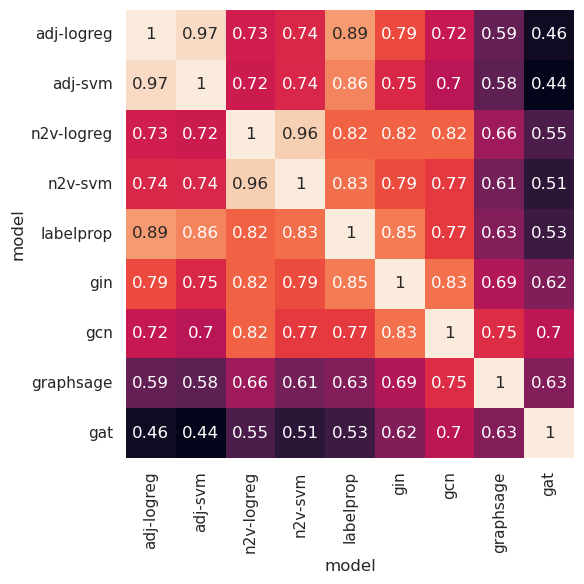

In [10]:
# Correlation of task-specific performance between models
plt.figure(figsize=(6, 6))
sns.heatmap(
    table[models].corr(),
    annot=True,
    cbar=False,
)
plt.tight_layout()
plt.show()

## Given a model and the tasks of interest, which network to use

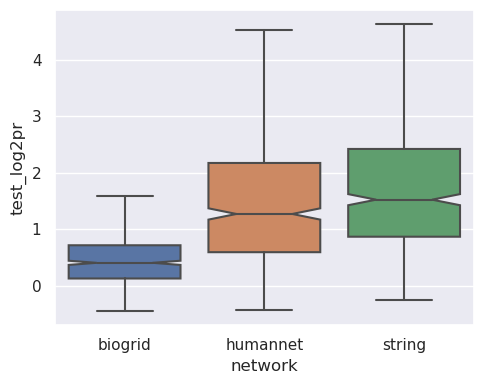

In [11]:
model = "gin"
label = "disgenet"
metric = "test_log2pr"

plt.figure(figsize=(5, 4))
sns.boxplot(
    data=(
        df
        .groupby(["label", "model"])
        .get_group((label, model))
    ),
    x="network",
    order=networks,
    y=metric,
    notch=True,
    showfliers=False,
)
plt.tight_layout()
plt.show()

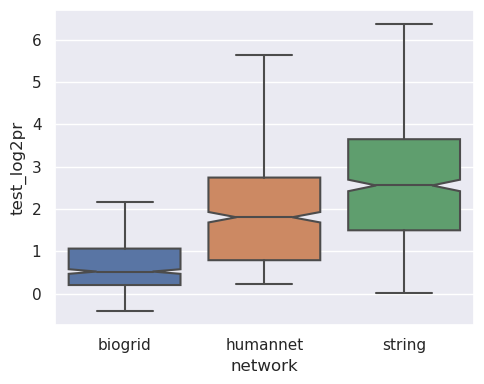

In [12]:
model = "adj-logreg"
label = "disgenet"
metric = "test_log2pr"

plt.figure(figsize=(5, 4))
sns.boxplot(
    data=(
        df
        .groupby(["label", "model"])
        .get_group((label, model))
    ),
    x="network",
    order=networks,
    y=metric,
    notch=True,
    showfliers=False,
)
plt.tight_layout()
plt.show()

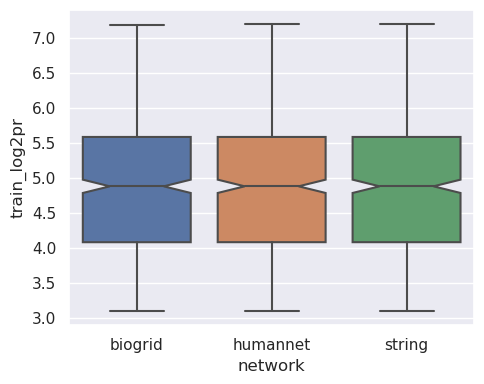

In [13]:
model = "adj-logreg"
label = "disgenet"
metric = "train_log2pr"

plt.figure(figsize=(5, 4))
sns.boxplot(
    data=(
        df
        .groupby(["label", "model"])
        .get_group((label, model))
    ),
    x="network",
    order=networks,
    y=metric,
    notch=True,
    showfliers=False,
)
plt.tight_layout()
plt.show()

## No universally optimal model

In [14]:
network = "humannet"
label = "disgenet"

sub_df = df.query("network == @network & label == @label")

In [15]:
mdl1 = "adj-logreg"
mdl2 = "gcn"

score_lst = []
for task, group_task in sub_df.groupby("task_name"):
    group_task_mdl = group_task.groupby("model")
    
    mdl1_scores = group_task_mdl.get_group(mdl1)[metric].values
    mdl2_scores = group_task_mdl.get_group(mdl2)[metric].values
    
    diff_score = mdl1_scores.mean() - mdl2_scores.mean()
    pval = scipy.stats.ttest_ind(mdl1_scores, mdl2_scores)[1]
    
    score_lst.append({
        "Task": task,
        f"{mdl1} mean": mdl1_scores.mean(),
        f"{mdl1} std": mdl1_scores.std(),
        f"{mdl2} mean": mdl2_scores.mean(),
        f"{mdl2} std": mdl2_scores.std(),
        "Difference mean": diff_score,
        "p-value": pval,
    })
    
pd.DataFrame(score_lst).sort_values("Difference mean")

,Task,adj-logreg mean,adj-logreg std,gcn mean,gcn std,Difference mean,p-value
104,DOID:700,6.224966,0.0,5.657095,0.252603,0.567872,2.012288e-03
9,DOID:0050758,5.629356,0.0,4.541860,0.233615,1.087497,1.443578e-05
27,DOID:10579,6.193257,0.0,4.943514,0.396070,1.249744,2.301135e-04
28,DOID:10584,5.162230,0.0,3.686470,0.656330,1.475761,2.010031e-03
122,DOID:9993,5.468892,0.0,3.970550,0.416290,1.498342,9.258248e-05
...,...,...,...,...,...,...,...
66,DOID:2033,4.883929,0.0,1.493676,0.566009,3.390253,2.171972e-06
38,DOID:11612,5.431418,0.0,1.996028,0.702537,3.435389,1.001962e-05
116,DOID:9741,5.273876,0.0,1.819546,0.326598,3.454330,2.620983e-08
103,DOID:693,6.716819,0.0,3.172508,1.382887,3.544311,9.005544e-04
